# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
sys.path.append('BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='drive/'
from algorithms import  Comb, Calibrator


In [2]:
# pip install fitsio

In [3]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee


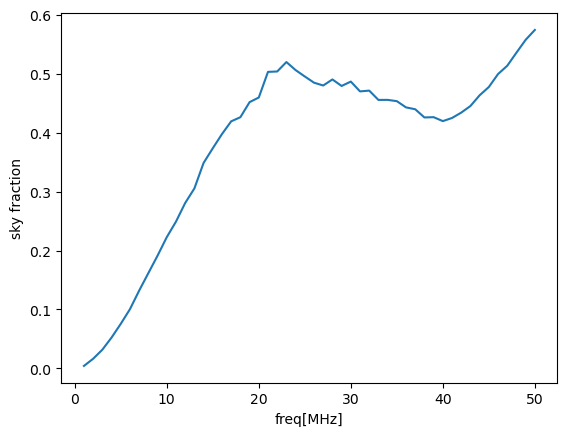

In [4]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction()) # frequency list, fraction of beam power that terminates on the sky
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear') # function of sky brightness by frequency




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

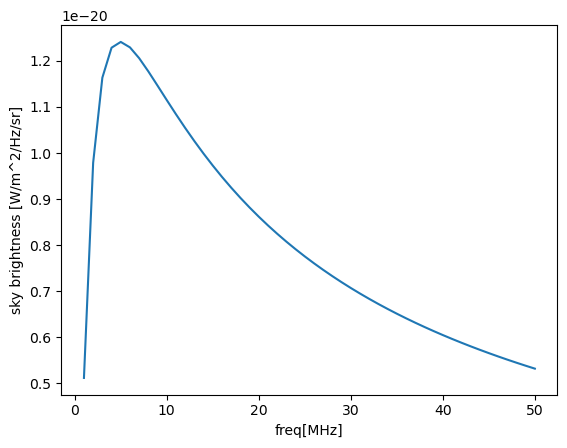

In [5]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq)) # sky brightness at observing frequencies
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 1e-17 W/m^2


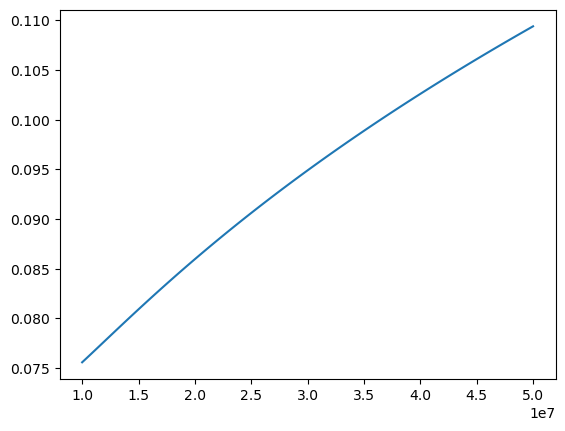

In [6]:
# define signal and sky signals
req_level = 1e-22 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

# find signal
def signal_rms(freq):
    freq_MHz = freq/1e6 # scale to MHz
    sf = sky_fraction(freq_MHz) 
    return np.sqrt(req_level*sf) # signal

# find noise
def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area # sky brightness scaled
    return np.sqrt(sky_signal) # total sky brightness (ie noise)


# plot signal to noise
freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [7]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms) # define a frequency comb
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=128) # establist calibrator object
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=0.4,tmax=20) # get analysis
# res['detect'], res['SNRdBdet'] # if S/N > 1.5 and drift small enough, S/N in db

1 7.627868008781467e-09 0.00019305767085167264 False
2 6.989928179623839e-09 0.00015245191233019127 False
3 4.759288204454922e-09 0.0001515926304322365 False
4 3.451818246328056e-09 8.814846207609689e-05 False
5 -2.650190728065672e-10 0.00011577348424030075 False
6 3.202106224832002e-09 -0.00012731895630907318 False
7 5.144830459900618e-09 1.7377225211517034e-05 False
8 3.0905595956156454e-09 5.088223724371702e-05 False
9 -2.6978801179908855e-11 -3.43141521727127e-05 False
10 2.4394030393452112e-09 -0.00012760026421993324 False
11 4.6416806205195795e-10 -1.8411863540910332e-05 False
12 -1.6123222238844152e-09 -0.00010171824524607851 False
13 -2.401652983954216e-10 5.3610249632120825e-05 False
14 -2.1591754400562358e-11 1.449883672930964e-07 False
15 2.5575810889668037e-09 0.000257542420639107 False
16 1.7140474316104702e-09 3.850515429174287e-05 False
17 2.13981896223537e-09 9.314141371375056e-05 False
18 -6.250728519940921e-09 -3.4960516473356545e-06 False
19 -3.247818110984297e-09 0.

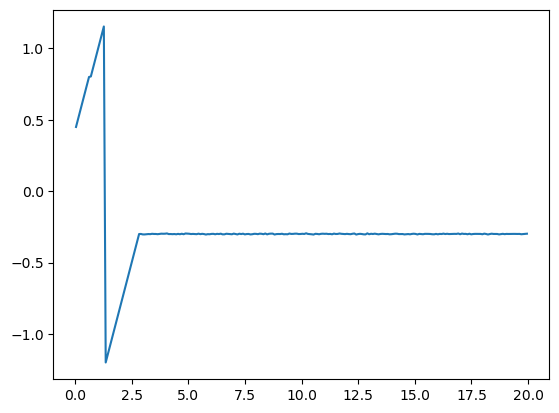

In [8]:
plt.plot(res['t'], res['alphadet']) # time vs how much phase change changes

#plt.xlim(0,1)

In [1]:
# FOR DEBUGGING - USED TWO VERSIONS OF ALGORTHIMS TO COMPARE THREE VS ALL TONES

# det_n = resn['detect']
# det_d = resd['detect']
# dif = []
# ddr = []
# for i in range(len(resd['FD'])):
#     if det_n[i] != det_d[i]:
#         dif.append([i+1, (resn['FD'][i] - resd['FD'][i])/resn['FD'][i],(resn['SD'][i] - resd['SD'][i])/resn['SD'][i]])
#         ddr.append([i+1, resn['FD'][i]/resn['SD'][i], resd['FD'][i]/resn['SD'][i]])
# dif = np.array(dif)
# ddr = np.array(ddr)
# np.mean(dif[:,1]),np.mean(dif[:,2])
# dif[:,1], dif[:,2], np.mean(np.abs(dif[:,1])), np.mean(np.abs(dif[:,2]))

In [9]:
# new comb and calibrator objects
comb=Comb(response=signal_rms, noise=noise_rms)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

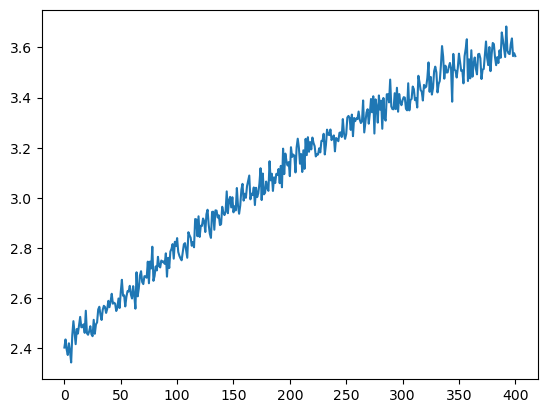

In [10]:
plt.plot(nb/wb) # narrow/wide bins, narrow should minimize noise
